# DBSCAN

Assumptions
* Densities across all the clusters are the same

* Cluster sizes or standard deviations are the same

Parameter selection:
* eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. It can be calculated with 2 methods: NearestNeighbors or the "knee" method

* min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. This is better determined by the own knowledge domain: choose a value that makes sense within the dataset working with.

* The rest of the parameters are left by default

Returns (attributes):
* core_sample_indices: Indices of core samples.

* components_: Copy of each core sample found by training.

* labels_: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1

In [1]:
%matplotlib inline
import math
import os
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns;
sns.set()
from collections import defaultdict
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
plt.rcParams["figure.figsize"] = (12,7)

C:\Users\lalaj\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
class VariantCall(object):
    """Read in variant call file and give access points to various types of data"""

    def __init__(self, file_path):
        """
        Initialize the class
        :param file_path: path to csv file
        """
        self.data = pd.read_csv(file_path)
        self.canonical = {"A", "C", "G", "T"}
        
    def get_subunit_data(self, subunit):  # assumes there is at least one read that covers all positions
        data = self.data.loc[self.data['contig'] == subunit]
        data_2 = data.groupby(['reference_index']).nunique()
        positions = []
        for i, row in data_2.iterrows():
            positions.append(i)
        return positions

    def get_reads_covering_positions_data(self, positions, plot=False):
        data = self.data[self.data['reference_index'].isin(positions)]
        plot_data = data.loc[:, ['read_id', 'reference_index', 'variants', 'prob1', 'prob2']]
        pos_n = len(positions)
        select = plot_data.groupby(['read_id']).nunique()
        select.columns = ['id_number', 'reference_index', 'variants', 'prob1', 'prob2']
        a = select[select['reference_index'] == pos_n]
        target_ids = list(a.index.values)
        d = {}
        for pos in positions:
            d[str(pos)] = []
        for i in target_ids:
            r = (plot_data.loc[plot_data['read_id'] == i]).set_index('reference_index')
            for index, row in r.iterrows():
                d[str(index)].append(r.at[index, 'prob2'])
        df_plot = pd.DataFrame(list(zip(target_ids)))
        df_plot.columns = ['read_id']
        for key in d:
            col_val = ''
            col_val += 'P' + ' ' + str(key)
            df_plot[col_val] = d[key]
        if plot:
            del df_plot['read_id']
        return df_plot

    ##Spectral clustering

    def spectral_clusters(self, positions):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        dists = squareform(pdist(X.values))  # ndarray
        neighbor_n = int(math.sqrt(len(positions)))
        knn_distances = np.sort(dists, axis=0)[neighbor_n]  # indexer is usually sqrt(number_of_data_points)
        knn_distances = knn_distances[np.newaxis].T
        local_scale = knn_distances.dot(knn_distances.T)
        a_matrix = dists * dists
        a_matrix = -a_matrix / local_scale
        a_matrix[np.where(np.isnan(a_matrix))] = 0.0
        a_matrix = np.exp(a_matrix)
        np.fill_diagonal(a_matrix, 0)  # now have a_matrix
        A = a_matrix
        L = csgraph.laplacian(A, normed=True)
        n_components = A.shape[0]
        eigenvalues, eigenvectors = eigsh(L, k=n_components, which='LM', sigma=1.0, maxiter=500)
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.xlabel('K clusters')
        plt.ylabel('Eigengap')
        axes = plt.gca()
        axes.set_xlim([-5, 80])
        return plt.grid()

    def spectral_affinity(self, positions, n_clusters):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        spectral_model_rbf = SpectralClustering(n_clusters=n_clusters, affinity='rbf')  # with any value for n_clusters
        labels_rbf = spectral_model_rbf.fit_predict(X)
        spectral_model_nn = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
        labels_nn = spectral_model_nn.fit_predict(X)
        affinity = ['rbf', 'nearest_neighbors']
        s_scores = [silhouette_score(X, labels_rbf), silhouette_score(X, labels_nn)]
        plt.bar(affinity, s_scores)
        plt.xlabel('Affinity')
        plt.ylabel('Silhouette Score')
        plt.title('Comparison of different Clustering Models')
        return plt.show()

    def spectral_clustering(self, positions, n_clusters=1, affinity=1, max_number_clusters=None, cluster_size=None,
                            eps=None, min_samples=None, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return SpectralClustering(n_clusters=n_clusters, affinity=affinity).fit(X), SpectralClustering(
            n_clusters=n_clusters, affinity=affinity).fit_predict(X)

    ##mean shift

    def mean_shift(self, positions, n_clusters=None, affinity=None, max_number_clusters=None, cluster_size=None,
                   eps=None, min_samples=None, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        quantile_data = X.to_numpy()
        quantile_val = np.quantile(quantile_data, 0.5)
        bandwidth = estimate_bandwidth(X, quantile=quantile_val)
        ms = MeanShift(bandwidth=bandwidth)
        mf = ms.fit(X)
        print('Number of clusters found: ', len(mf.cluster_centers_))
        return mf, ms.fit_predict(X)

    ##K means

    def k_means_clusters(self, positions, max_number_clusters):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(1, max_number_clusters + 1))
        v = visualizer.fit(X)
        v.show()
        return KMeans(n_clusters=v.elbow_value_).fit(X)

    def k_means(self, positions, n_clusters=None, affinity=None, max_number_clusters=1, cluster_size=None,
                eps=None, min_samples=None, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(1, max_number_clusters + 1))
        v = visualizer.fit(X)
        v.show()
        return KMeans(n_clusters=v.elbow_value_).fit(X), KMeans(n_clusters=v.elbow_value_).fit_predict(X)

    ##HDBSCAN

    def HDBSCAN(self, positions, n_clusters=None, affinity=None, max_number_clusters=None, cluster_size=1,
                eps=None, min_samples=None, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return hdbscan.HDBSCAN(min_cluster_size=cluster_size, gen_min_span_tree=True).fit(X), hdbscan.HDBSCAN(
            min_cluster_size=cluster_size, gen_min_span_tree=True).fit_predict(X)

    ##DBSCAN

    def DBSCAN_eps(self, positions):
        X = self.get_reads_covering_positions_data(positions)
        del X['read_id']
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(X)
        distances, indices = nbrs.kneighbors(X)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        a = plt.plot(distances)
        plt.xlabel('Points')
        plt.ylabel('eps value')
        print(a)
        i = np.arange(len(distances))
        knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
        fig = plt.figure()
        knee.plot_knee()
        plt.xlabel('Points')
        plt.ylabel('eps')
        print('Optimal eps value: ', distances[knee.knee])

    def DBSCAN(self, positions, n_clusters=None, affinity=None, max_number_clusters=None, cluster_size=None,
               eps=1, min_samples=1, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        X = StandardScaler().fit_transform(X)
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit(X).labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('Estimated number of clusters: ', n_clusters_)
        return db.fit(X), db.fit_predict(X)

    ##Agglomerative clustering

    def get_dendrogram(self, positions, y1=0, y2=0, y3=0):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        hierarchy.dendrogram(linkage(X, method='single'), labels=X.index)
        left, right = plt.xlim()
        plt.hlines(y1, left, right, linestyles='dashed', label='y1')
        plt.hlines(y2, left, right, linestyles='dashed', label='y2')
        plt.hlines(y3, left, right, linestyles='dashed', label='y3')
        plt.ylabel('Euclidean Distance')
        plt.title('Dendrogram of subunit data')
        plt.text(right, y1, 'y1')
        plt.text(right, y2, 'y2')
        plt.text(right, y3, 'y3')
        return plt.show()

    def agglomerative_clustering(self, positions, n_clusters=1, affinity=None, max_number_clusters=None,
                                 cluster_size=None,
                                 eps=None, min_samples=None, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return AgglomerativeClustering(n_clusters=n_clusters).fit(X), AgglomerativeClustering(
            n_clusters=n_clusters).fit_predict(X)

    ##affinity propagation

    def affinity_propagation(self, positions, n_clusters=None, affinity=None, max_number_clusters=None,
                             cluster_size=None, eps=None, min_samples=None, n_components=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return AffinityPropagation().fit(X), AffinityPropagation().fit_predict(X)

    ##Gaussian mixture models

    def gaussian_mixture_models_cluster(self, positions, n_clusters=None, affinity=None, max_number_clusters=None,
                                        cluster_size=None, eps=None, min_samples=None, n_components=1):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return GaussianMixture(n_components=n_clusters).fit(X), GaussianMixture(n_components=n_clusters).fit_predict(X)

    ##plot

    def plot_tSNE_reads_covering_positions_data(self, positions, clustering_algorithm, n_clusters=2,
                                                affinity='nearest_neighbors', max_number_clusters=10, cluster_size=10,
                                                eps=2, min_samples=10, n_components=4, figure_path=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        tsne = TSNE(n_components=2, random_state=0)
        tsne_results = tsne.fit_transform(X)
        method_to_call = getattr(self, clustering_algorithm)
        fit, predictor = method_to_call(positions, n_clusters, affinity, max_number_clusters, cluster_size, eps,
                                        min_samples, n_components)
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=predictor, s=30, cmap='rainbow')
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.title(str(len(positions)) + ' ' + 'positions' + ' ' + clustering_algorithm)
        if figure_path is not None:
            assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
            plt.savefig(figure_path)
        else:
            plt.show()
        return figure_path

In [7]:
#from read_clustering.variant_call import VariantCall
path = 'C:/Users/lalaj/PycharmProjects/untitled3/read_clustering/tests/test_files/native_cbf5_gal.csv'
native = VariantCall(path)

In [8]:
list_18 = native.get_subunit_data('RDN18-1')
list_25 = native.get_subunit_data('RDN25-1')

# Determine eps value

*NearestNeighbors*

The eps value is proportional 8and very close) to the expected number of neighbours discovered with these method.
* The desirable eps value is located at the "inflection" point of the graph. It is the maximum value where distance between points can be kept low enough to define clusters.
* As this graph can show more than one curve, it is better to visualize it and manually input the desirable eps.

*Knee method*

* Uses the python library *kneed*. Proposed by Ville Satopa et al. (2011)

* Has a similar graphical output, where the dashed line indicates the inflection point.

The method is stated in the VariantCall

Optimal eps value:  1.7104720142341823


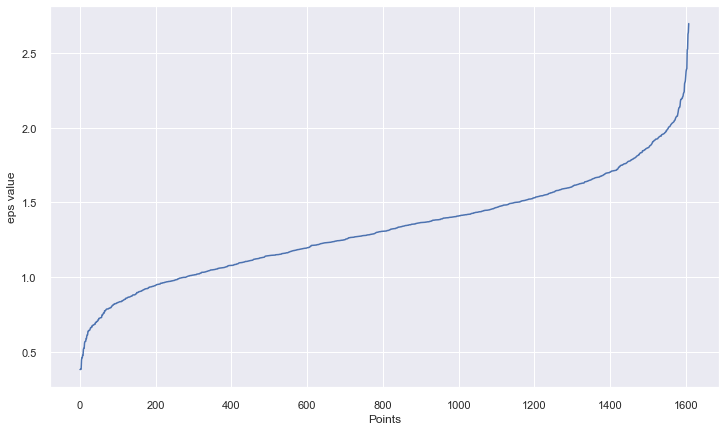

<Figure size 864x504 with 0 Axes>

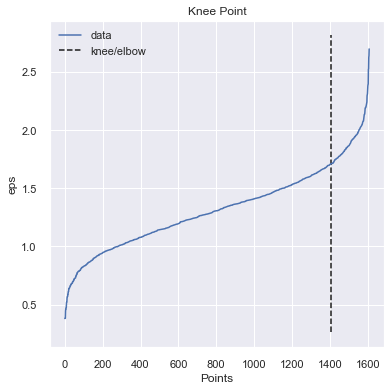

In [14]:
native.DBSCAN_eps(list_18)

Optimal eps value:  2.8286139904049534


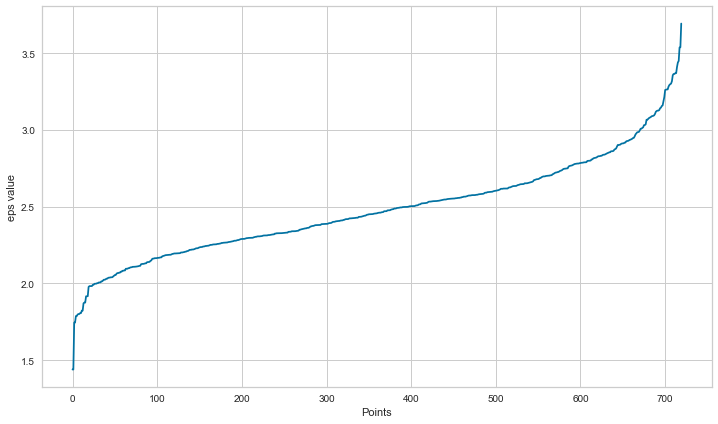

<Figure size 864x504 with 0 Axes>

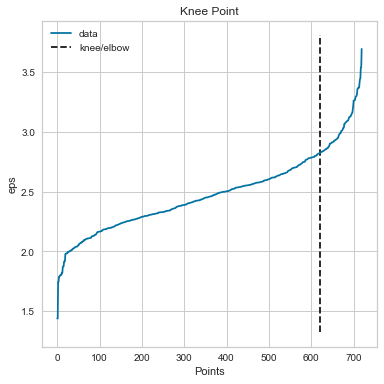

In [9]:
native.DBSCAN_eps(list_25) 

As seen in the very similar graphs and as indicated by the knee method, an optimal eps is around 1.9 for 18S and 2.8 for 25S.

Min_samples can be estimated to be around 1/20 of the total data points. For 18S this is ~ 90 and for 25S ~ 40

Plotting with selected parameters (purple is noise):

In 18S, applies 2 colors to the dataset, but looking at the labels_ array, all points are classified as -1: as noise. It identifies no clusters, regardless of how low the min_samples value is set.

Estimated number of clusters:  0


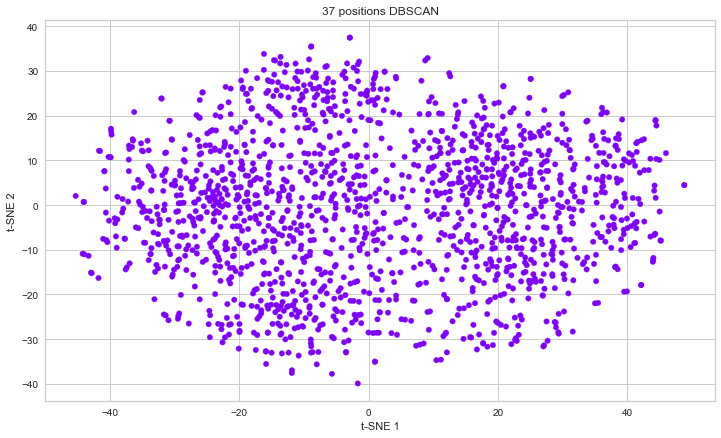

In [11]:
#18S
native.plot_tSNE_reads_covering_positions_data(list_18, 'DBSCAN', eps = 1.9, min_samples =90) 

Identifies no clusters either in 25S.

Estimated number of clusters:  0


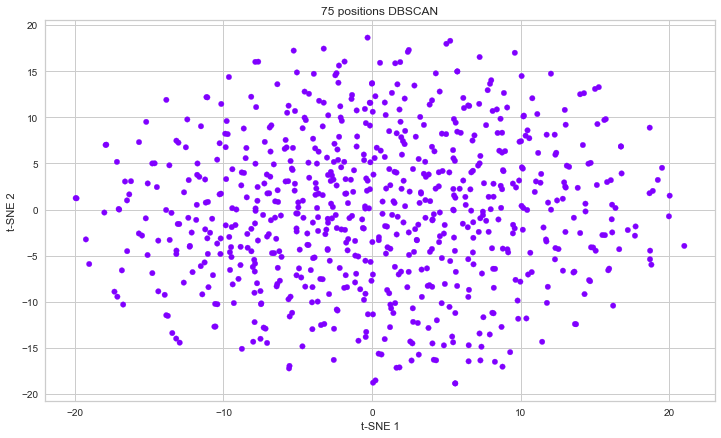

In [10]:
#25S
native.plot_tSNE_reads_covering_positions_data(list_25, 'DBSCAN', eps = 2.8, min_samples = 40) 